In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Input
from keras.models import Model, Sequential
warnings.filterwarnings('ignore')
import os

In [ ]:
dataset = pd.read_csv('/content/eng_-french.csv', on_bad_lines='skip', quoting= 3)
dataset = dataset.dropna(axis = 0)
english_tokenizer = Tokenizer(oov_token="<OOV>")
french_tokenizer = Tokenizer(oov_token="<OOV>", filters= '')

In [ ]:
X = dataset['English words/sentences']
y = dataset['French words/sentences']
y_inputs = y.apply(lambda y: "<start> " + y )
y_outputs = y.apply(lambda y: y + " <end>")
english_tokenizer.fit_on_texts(X)
french_tokenizer.fit_on_texts(y_inputs + y_outputs)

In [ ]:
english_tokenized_text = english_tokenizer.texts_to_sequences(X)
french_input_tokenized_text = french_tokenizer.texts_to_sequences(y_inputs)
french_output_tokenized_text = french_tokenizer.texts_to_sequences(y_outputs)

In [ ]:
def get_padding(data):
  """
  This functions pads lengths with zeros to get
  balanced with the maximum length in the dataset.
  Author@Afolabi Akinola

  """
  padding = []
  max_length = max(len(seq) for seq in data)
  for sequence in data:
    usual_length = len(sequence)
    if usual_length < max_length:
      difference = max_length - usual_length
      padding_method = np.zeros(difference)
      padded = np.concatenate((sequence, padding_method))
    else:
      padded = sequence
    padding.append(padded)
  return np.array(padding, dtype = 'int32')




In [ ]:
y_inputted =get_padding(french_input_tokenized_text)
y_outputted =get_padding(french_output_tokenized_text)
x = get_padding(english_tokenized_text)
source_vocab_size = len(english_tokenizer.word_index) + 1
target_vocab_size = len(french_tokenizer.word_index) + 1
embedding_dim = 256
latent_dim = 512

In [ ]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [ ]:
encoded_inputs = Input(shape = (None, ))
encoded_embedding = Embedding(source_vocab_size, embedding_dim, mask_zero= True)(encoded_inputs)
encoder_lstm = LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(encoded_embedding)
encoder_states = [state_h, state_c]
decoder_inputs = Input(shape = (None, ))
decoder_embedding = Embedding(target_vocab_size, embedding_dim, mask_zero= True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state = encoder_states)
decoder_dense = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
translation_model = Model([encoded_inputs, decoder_inputs], decoder_outputs)
translation_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
translation_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  3,556,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │ 26,070,528 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │ 52,242,894 │ lstm_1[0][0]      │
│                     │ 101838)           │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,019,342 (324.32 MB)

 Trainable params: 85,019,342 (324.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_outputted = np.expand_dims(y_outputted, axis = -1)
y_outputted.shape, translation_model.output_shape

((161631, 34, 1), (None, None, 101838))

In [ ]:
history = translation_model.fit([x, y_inputted], y_outputted,
                                validation_split= 0.4, epochs = 5, batch_size = 32)

Epoch 1/5
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 1113s 367ms/step - loss: 5.2077 - val_loss: 4.2026
Epoch 2/5
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 1119s 369ms/step - loss: 2.4562 - val_loss: 3.7591
Epoch 3/5
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 1162s 369ms/step - loss: 1.5167 - val_loss: 3.6584
Epoch 4/5
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 1161s 369ms/step - loss: 0.9854 - val_loss: 3.7198
Epoch 5/5
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 1162s 369ms/step - loss: 0.6967 - val_loss: 3.8228


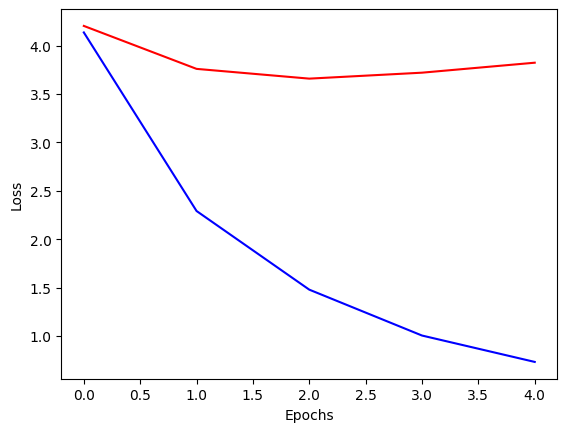

In [ ]:
plt.plot(history.history['loss'], color = 'blue', label = 'Training Loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();

In [ ]:

json_model = translation_model.to_json()

In [ ]:
french_tokenizer.word_index['']

In [ ]:
def make_inference_models():
    encoder_model = Model(encoded_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )
    return encoder_model, decoder_model


def translate_sentence(input_sentence, encoder_model, decoder_model, english_tokenizer, french_tokenizer):
    input_sequence = english_tokenizer.texts_to_sequences([input_sentence])
    input_padded = get_padding(input_sequence)
    states_value = encoder_model.predict(input_padded)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = french_tokenizer.word_index["<start>"]
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = french_tokenizer.index_word.get(sampled_token_index, "")
        decoded_sentence += " " + sampled_word
        if sampled_word == "<end>" or len(decoded_sentence.split()) > 50:
            stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.replace("<end>", "").strip()

# Example usage after training:
encoder_model, decoder_model = make_inference_models()
input_text = "Good morning"
french_translation = translate_sentence(input_text, encoder_model, decoder_model, english_tokenizer, french_tokenizer)
print("English:", input_text)
print("French:", french_translation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
English: Good morning
French: bonjour.
